In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# 数据整理

In [15]:
df=pd.read_csv('Customer-Churn-Records.csv')
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
df = pd.get_dummies(df, columns=['Card'], drop_first=True)
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df = df.iloc[:,3:]
df.iloc[:,-6:] = df.iloc[:,-6:].apply(lambda x: x.astype(int))
df[['Balance', 'EstimatedSalary']] = (df[['Balance', 'EstimatedSalary']]+0.000001).apply(np.log)
df.columns=['信用评分','年龄','客龄','log(余额)','购买产品数','持有信用卡','活跃客户','log(预估工资)','客户流失','满意度','信用卡积分','德国','西班牙','黄金卡','铂金卡','白银卡','性别']

C:\Users\dell\AppData\Local\Temp\ipykernel_37988\2401333304.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    1
9999    0
Name: Geography_Germany, Length: 10000, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,-6:] = df.iloc[:,-6:].apply(lambda x: x.astype(int))
C:\Users\dell\AppData\Local\Temp\ipykernel_37988\2401333304.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       1
2       0
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Geography_Spain, Length: 10000, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,-6:] = df.iloc[:,-6:].apply(lambda x: x.astype(int))
C:\U

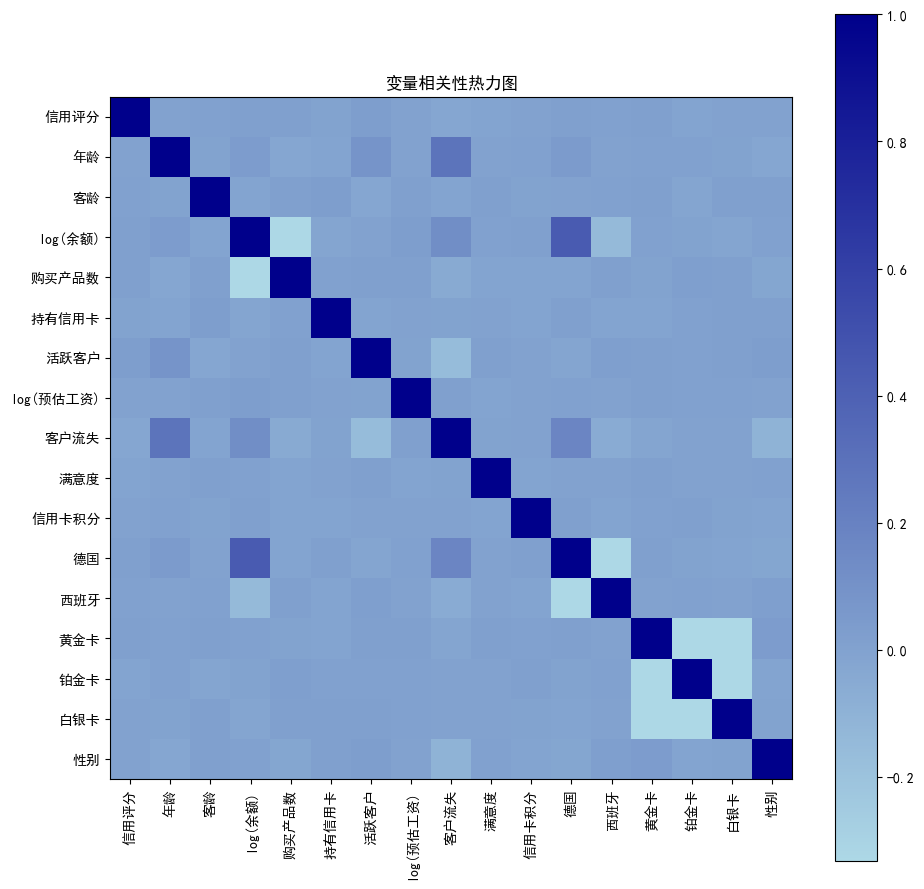

In [19]:
custom_cmap = LinearSegmentedColormap.from_list("blue_to_darkblue", ['#add8e6', '#00008b'])
plt.figure(figsize=(11,11))
plt.rcParams['axes.unicode_minus']=False
plt.imshow(df.corr(), cmap=custom_cmap)
plt.colorbar()
plt.title('变量相关性热力图')
plt.xticks(ticks=np.arange(len(df.corr().columns)), labels=df.corr().columns, rotation=90)
plt.yticks(ticks=np.arange(len(df.corr().columns)), labels=df.corr().columns)
plt.rcParams['font.sans-serif']=['SimHei']
plt.savefig('heatmap.jpg',dpi=400)
plt.show()

In [20]:
def vif_feature(x):
    if not isinstance(x, pd.DataFrame):
        raise ValueError(f"输入数据 x 必须是 pandas DataFrame 格式，但当前是 {type(x)}")
    X_with_constant = sm.add_constant(x)
    while True:
        vif = pd.DataFrame()
        vif['Variable'] = X_with_constant.columns
        vif['VIF'] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
        print(vif)
        max_vif = vif['VIF'].max()
        if max_vif > 10:
            variable_to_remove = vif.loc[vif['VIF'] == max_vif, 'Variable'].values[0]
            X_with_constant = X_with_constant.drop(variable_to_remove, axis=1)
        else:
            break
    return list(vif['Variable'])

In [23]:
np.random.seed(42)
x = df.drop(['客户流失'], axis=1)
l = vif_feature(x)
X = df[l]
y = df['客户流失']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

     Variable         VIF
0       const  217.534825
1        信用评分    1.001523
2          年龄    1.012146
3          客龄    1.002582
4     log(余额)    1.422771
5       购买产品数    1.152942
6       持有信用卡    1.002018
7        活跃客户    1.011211
8   log(预估工资)    1.001462
9         满意度    1.001070
10      信用卡积分    1.001190
11         德国    1.394412
12        西班牙    1.124879
13        黄金卡    1.501017
14        铂金卡    1.499545
15        白银卡    1.499694
16         性别    1.004317
     Variable        VIF
0        信用评分  36.591253
1          年龄  13.960925
2          客龄   3.966498
3     log(余额)   1.477192
4       购买产品数   8.845132
5       持有信用卡   3.359770
6        活跃客户   2.082206
7   log(预估工资)  53.554566
8         满意度   5.450769
9       信用卡积分   7.911554
10         德国   1.860837
11        西班牙   1.491762
12        黄金卡   1.989305
13        铂金卡   1.982018
14        白银卡   1.983063
15         性别   2.193618
   Variable        VIF
0      信用评分  23.568207
1        年龄  12.612186
2        客龄   3.887715
3   log(余额)   1

# 逻辑回归

In [24]:
def stepwise_selection(X, y,
                       threshold_in=0.1,
                       threshold_out = 0.1,
                       verbose = True):
    if not np.all(np.isin(np.unique(y), [0, 1])):
        raise ValueError(f"目标变量 y 的值包含非法标签！只允许0和1")
    included = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, pd.DataFrame(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            best_feature = new_pval.index[best_feature]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
 
        # backward step
        model = sm.Logit(y, pd.DataFrame(X[included])).fit()
        # use all coefs except intercept
        pvalues = model.pvalues
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature = pvalues.index[worst_feature]
            print(worst_feature)
            print(included)
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return model,included

In [25]:
final_model,selected_features = stepwise_selection(X_train, y_train)
print(final_model.summary())

Optimization terminated successfully.
         Current function value: 0.646144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560676
  

Accuracy on test set: 0.80700000
混淆矩阵:
[[1583   24]
 [ 362   31]]


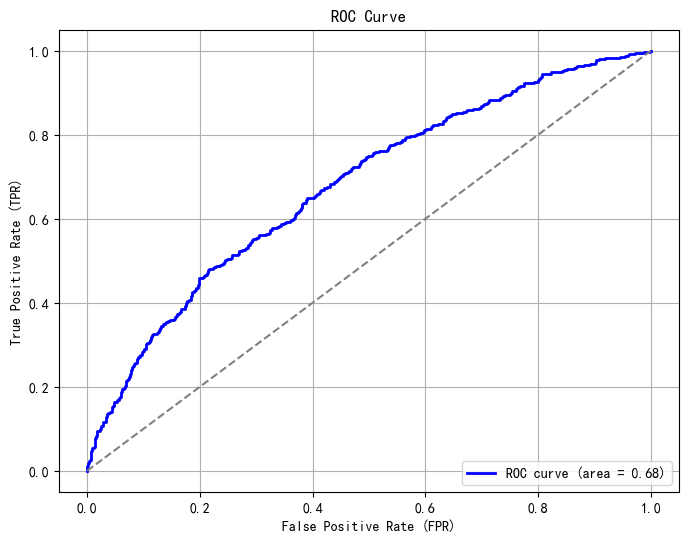

In [26]:
def auc_roc(y_test,y_prob,label):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 计算混淆矩阵
    y_pred = y_prob >= 0.5
    cm = confusion_matrix(y_test, y_pred)
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy on test set: {accuracy:.8f}")
    print("混淆矩阵:")
    print(cm)
    
    # 绘制 ROC 曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('{}.jpg'.format(label),dpi=500)
    plt.show()
from sklearn.metrics import confusion_matrix

X_test_selected = X_test[list(selected_features)]
y_prob = final_model.predict(X_test_selected)
auc_roc(y_test,y_prob,label='logit')

# 随机森林

In [27]:
rf_model = RandomForestClassifier(random_state=42)
# 设置超参数网格
param_grid = {
    'n_estimators': [100, 200, 300],  # 树的数量
    'max_depth': [None, 10, 20, 30],   # 树的最大深度
    'min_samples_split': [2, 5, 10],   # 每个节点的最小样本数
    'min_samples_leaf': [2, 4],     # 每个叶子节点的最小样本数
    'bootstrap': [True, False]         # 是否使用bootstrap抽样
}

# 使用 GridSearchCV 调整超参数
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
print(f'Accuracy on test set: {best_rf_model.score(X_test, y_test):.4f}')


Fitting 5 folds for each of 144 candidates, totalling 720 fits


d:\anaconda_2\jupyterlab\venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy on test set: 0.8335


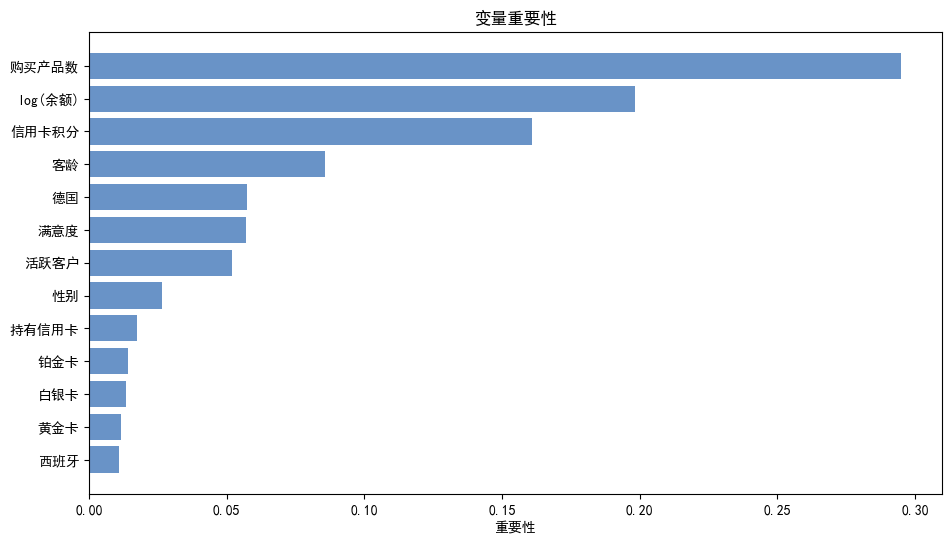

Accuracy on test set: 0.83350000
混淆矩阵:
[[1554   53]
 [ 280  113]]


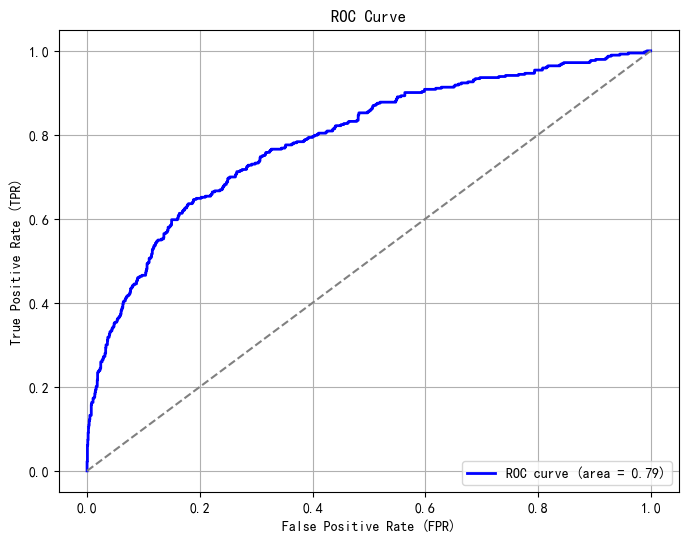

In [29]:
# 获取最佳模型的特征重要性
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# 横向条形图
plt.figure(figsize=(11, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=(79/255, 128/255, 189/255),alpha=0.85)
plt.xlabel('重要性')
plt.title('变量重要性')
plt.savefig('feature_importance.jpg',dpi=500)
plt.show()

y_prob = best_rf_model.predict_proba(X_test)
auc_roc(y_test,y_prob[:,1],'rf')

In [11]:
# 创建SVM分类器
svm = SVC(probability=True, random_state=42)
from sklearn.preprocessing import StandardScaler

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义调参网格
param_grid = {
    'C': [0.1,1,10],
    'kernel': ['linear', 'rbf','sigmoid']
}

# 使用GridSearchCV来调参
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=3)

# 训练模型并调参
grid_search.fit(X_train_scaled, y_train)

# 打印最佳参数
print("最佳参数：", grid_search.best_params_)

# 使用最佳参数进行预测
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test_scaled)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.794 total time=   2.3s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.794 total time=   2.4s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.794 total time=   4.1s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.794 total time=   2.5s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.794 total time=   2.3s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.804 total time=   6.8s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.801 total time=   7.6s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.803 total time=   6.8s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.805 total time=   6.8s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.802 total time=   7.5s
[CV 1/5] END .............C=0.1, kernel=sigmoid;, score=0.793 total time=   6.2s
[CV 2/5] END .............C=0.1, kernel=sigmoid;,

Accuracy on test set: 0.82400000
混淆矩阵:
[[1562   45]
 [ 307   86]]


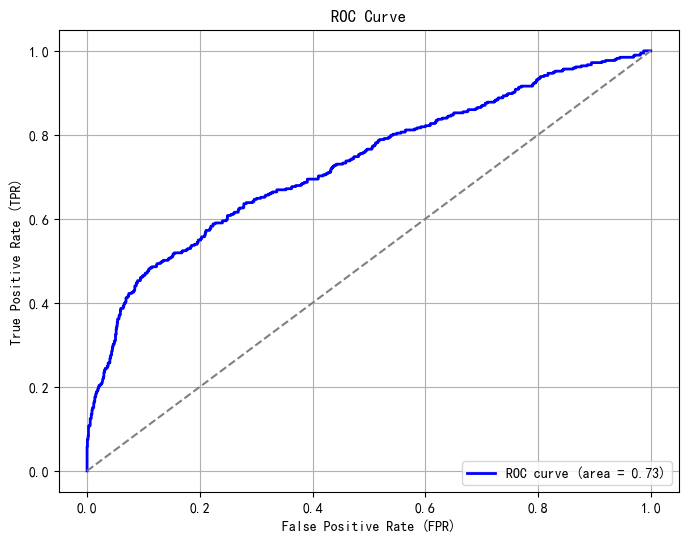

In [12]:
auc_roc(y_test,y_prob[:,1],'svm')